# Run-to-Run Comparison

Compare probabilistic labels from two different BYOL embedding experiments (e.g., different model architectures, training data, or hyperparameters).

This notebook:
1. Loads embeddings from two different experiment directories
2. Applies the same classification method to both (NN by default, with K-NN fallback)
3. Generates probabilistic labels from both runs
4. Compares classification performance and label distributions
5. Visualizes differences in merger classification between runs

**Use cases:**
- Compare different BYOL model architectures or training approaches
- Evaluate impact of different input features (e.g., fiducial vs broadband-only)
- A/B test hyperparameter changes
- Understand systematic differences between experimental runs
- Identify cases where runs disagree

## Setup and Imports

In [1]:
import os
os.chdir('/Users/kadofong/work/projects/merian/pieridae/merger_analysis/notebooks')

In [2]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path

# Add pieridae to path
sys.path.insert(0, str(Path.cwd().parents[1]))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import pickle
import logging
from typing import Dict, Tuple

from pieridae.starbursts.byol import (
    EmbeddingAnalyzer,
    LabelPropagation,
    compute_classification_metrics
)

# Import make_punchlines module
sys.path.insert(0, str(Path.cwd().parent / 'figure_generation'))
import make_punchlines

# Plotting utilities
from ekfplot import plot as ek, colors as ec, colorlists

/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/umap/__init__.py:9: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn(


In [3]:
def load_image_by_name(img_name: str, data_path: Path) -> np.ndarray:
    """
    Load a single galaxy image on-demand.
    
    Parameters
    ----------
    img_name : str
        Galaxy ID (e.g., 'M1234567890123456789')
    data_path : Path
        Base data directory path
    
    Returns
    -------
    image : np.ndarray
        Image array with shape (3, H, W) containing [g-band, i-band, hf_i-band]
    """
    i_file = data_path / img_name / f"{img_name}_i_results.pkl"
    g_file = data_path / img_name / f"{img_name}_g_results.pkl"
    
    img = []
    for band_file in [g_file, i_file]:
        with open(band_file, 'rb') as f:
            xf = pickle.load(f)
            img.append(xf['image'])
            if band_file == i_file:
                img.append(xf['hf_image'])  # Add HF image for i-band
    
    return np.array(img, dtype=np.float32)

print("✅ Image loading helper function defined")

✅ Image loading helper function defined


## Configuration

In [4]:
# Load base config (we'll override output paths for each run)
config_path = '../config.yaml'
base_config = make_punchlines.load_config(config_path)

# Setup logger
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

print(f"📋 Base configuration loaded from: {config_path}")
print(f"📂 Data path: {base_config['data']['input_path']}")

📋 Base configuration loaded from: ../config.yaml
📂 Data path: ../../local_data/pieridae_output/starlet/msorabove_v0


## Define Runs to Compare

In [5]:
# Define experimental runs to compare
runs = {
    'run1': {
        'path': Path('../output/reference/'),
        'label': 'ref',
        'color': 'C0',
        'description': 'Baseline BYOL model with standard hyperparameters'
    },
    'run2': {
        'path': Path('../output/fiducial/'),
        'label': 'fid',
        'color': 'C1',
        'description': 'Modified BYOL model with different configuration'
    }
}

# Classifier configuration
# Set to True to use NN classifier, False for K-NN
# Will automatically fallback to K-NN if NN is not available
prefer_nn_classifier = True

print("🔧 Experimental runs:")
for name, run in runs.items():
    print(f"   {name}: {run['label']}")
    print(f"      Path: {run['path']}")
    print(f"      {run['description']}")

print(f"\n📊 Classifier preference: {'Neural Network (with K-NN fallback)' if prefer_nn_classifier else 'K-NN'}")

🔧 Experimental runs:
   run1: ref
      Path: ../output/reference
      Baseline BYOL model with standard hyperparameters
   run2: fid
      Path: ../output/fiducial
      Modified BYOL model with different configuration

📊 Classifier preference: Neural Network (with K-NN fallback)


## Load Data from Both Runs

In [6]:
# Load data from both runs
data = {}
classifier_used = {}

for name, run in runs.items():
    print(f"\n{'='*70}")
    print(f"Loading data from {run['label']}...")
    print(f"{'='*70}")
    
    # Create config for this run
    run_config = base_config.copy()
    run_config['data']['output_path'] = run['path']
    
    # Try to load with preferred classifier first
    use_nn = prefer_nn_classifier
    load_success = False
    
    for attempt in range(2):  # Try both classifiers if needed
        try:
            print(f"\n  Attempting to load with {'NN' if use_nn else 'K-NN'} classifier...")
            
            data[name] = make_punchlines.load_data(
                run_config,
                logger,
                use_nn_classifier=use_nn
            )
            
            classifier_used[name] = 'Neural Network' if use_nn else 'K-NN'
            load_success = True
            
            print(f"\n✅ Loaded data from {name} with {classifier_used[name]} classifier")
            print(f"   Embeddings shape: {data[name]['embeddings'].shape}")
            print(f"   Number of objects: {len(data[name]['img_names'])}")
            print(f"   Probabilistic labels shape: {data[name]['prob_labels_iter'].shape}")
            
            break
            
        except Exception as e:
            if attempt == 0:  # First attempt failed, try other classifier
                print(f"  ⚠️  Failed with {'NN' if use_nn else 'K-NN'} classifier: {e}")
                use_nn = not use_nn
                print(f"  Falling back to {'NN' if use_nn else 'K-NN'} classifier...")
            else:  # Both attempts failed
                print(f"\n❌ Error: Could not load data from {name} with either classifier")
                print(f"   Last error: {e}")
                break

if len(data) < 2:
    print("\n⚠️  Warning: Need both runs to compare!")
else:
    print(f"\n✅ Loaded data from {len(data)} runs for comparison")
    
    # Show which classifiers were used
    print("\n📊 Classifiers used:")
    for name in data.keys():
        print(f"   {runs[name]['label']}: {classifier_used[name]}")
    
    # Warn if different classifiers were used
    if len(set(classifier_used.values())) > 1:
        print("\n⚠️  Warning: Different classifiers used for different runs!")
        print("   This may affect comparison validity.")


Loading data from ref...

  Attempting to load with NN classifier...


2025-11-11 08:09:32,257 - INFO - Computing PCA...
2025-11-11 08:09:32,515 - INFO - PCA components: 20
2025-11-11 08:09:32,515 - INFO - Explained variance: 94.0%
/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kadofong/work/projects/merian/carpenter/src/carpenter/emission.py:338: RuntimeWarning: divide by zero encountered in reciprocal
  emission_correction = correct_NIISII(redshift_values, aperture_corrected_logmass)**-1


Computed aperture correction in 0.0 seconds.
Computed line contamination correction in 0.0 seconds.
Loading precomputed Galactic extinction map...
Interpolated Galactic extinction values from map.
Computed Galactic extinction correction in 0.7 seconds.
Computed internal extinction corrections in 0.7 seconds.


/Users/kadofong/work/projects/merian/agrias/python/agrias/photometry.py:115: RuntimeWarning: invalid value encountered in log10
  lsq_y = np.log10(np.array([ fdict[band] for band in plawbands ]))
/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Loading masses:   0%|                                                           | 0/54859 [00:00<?, ?it/s]/Users/kadofong/work/projects/merian/pieridae/merger_analysis/figure_generation/make_punchlines.py:309: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta


✅ Loaded data from run1 with Neural Network classifier
   Embeddings shape: (22913, 512)
   Number of objects: 22913
   Probabilistic labels shape: (22913, 6)

Loading data from fid...

  Attempting to load with NN classifier...


2025-11-11 08:10:00,920 - INFO - Computing PCA...
2025-11-11 08:10:01,153 - INFO - PCA components: 20
2025-11-11 08:10:01,153 - INFO - Explained variance: 93.2%
/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kadofong/work/projects/merian/carpenter/src/carpenter/emission.py:338: RuntimeWarning: divide by zero encountered in reciprocal
  emission_correction = correct_NIISII(redshift_values, aperture_corrected_logmass)**-1


Computed aperture correction in 0.0 seconds.
Computed line contamination correction in 0.0 seconds.
Loading precomputed Galactic extinction map...
Interpolated Galactic extinction values from map.
Computed Galactic extinction correction in 0.7 seconds.
Computed internal extinction corrections in 0.7 seconds.


/Users/kadofong/work/projects/merian/agrias/python/agrias/photometry.py:115: RuntimeWarning: invalid value encountered in log10
  lsq_y = np.log10(np.array([ fdict[band] for band in plawbands ]))
/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Loading masses:   0%|                                                           | 0/54859 [00:00<?, ?it/s]/Users/kadofong/work/projects/merian/pieridae/merger_analysis/figure_generation/make_punchlines.py:309: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta


✅ Loaded data from run2 with Neural Network classifier
   Embeddings shape: (22913, 512)
   Number of objects: 22913
   Probabilistic labels shape: (22913, 6)

✅ Loaded data from 2 runs for comparison

📊 Classifiers used:
   ref: Neural Network
   fid: Neural Network


In [7]:
# Verify that both runs processed the same galaxies
run_names = list(data.keys())
if len(run_names) >= 2:
    img_names_0 = data[run_names[0]]['img_names']
    img_names_1 = data[run_names[1]]['img_names']
    
    if not np.array_equal(img_names_0, img_names_1):
        print("⚠️  Warning: Runs have different galaxy sets!")
        print(f"   {runs[run_names[0]]['label']}: {len(img_names_0)} galaxies")
        print(f"   {runs[run_names[1]]['label']}: {len(img_names_1)} galaxies")
        
        # Find common galaxies
        common_names = np.intersect1d(img_names_0, img_names_1)
        print(f"   Common galaxies: {len(common_names)}")
        
        # Subset to common galaxies
        for name in run_names:
            mask = np.isin(data[name]['img_names'], common_names)
            data[name]['embeddings'] = data[name]['embeddings'][mask]
            data[name]['img_names'] = data[name]['img_names'][mask]
            data[name]['prob_labels_iter'] = data[name]['prob_labels_iter'][mask]
        
        img_names = common_names
        print(f"   ✅ Subset to {len(img_names)} common galaxies")
    else:
        img_names = img_names_0
        print(f"✅ Both runs processed the same {len(img_names)} galaxies")
else:
    img_names = data[run_names[0]]['img_names']

✅ Both runs processed the same 22913 galaxies


## Load Ground Truth Labels

In [8]:
# Load ground truth labels
label_file = Path(base_config.get('labels', {}).get('classifications_file', ''))

if label_file.exists():
    mergers = pd.read_csv(label_file, index_col=0)
    labels = mergers.reindex(img_names)
    labels = labels.replace(np.nan, 0).values.flatten().astype(int)
    
    print(f"✅ Loaded {len(labels)} labels")
    
    # Print distribution
    label_meanings = base_config.get('labels', {}).get('label_mapping', {})
    unique, counts = np.unique(labels, return_counts=True)
    
    print("\n📊 Label distribution:")
    for label_val, count in zip(unique, counts):
        meaning = label_meanings.get(label_val, f"unknown_{label_val}")
        pct = 100 * count / len(labels)
        print(f"   {label_val} ({meaning}): {count} objects ({pct:.1f}%)")
else:
    print(f"⚠️  Label file not found: {label_file}")
    labels = np.zeros(len(img_names), dtype=int)

✅ Loaded 22913 labels

📊 Label distribution:
   0 (unclassified): 19960 objects (87.1%)
   1 (undisturbed): 2314 objects (10.1%)
   2 (ambiguous): 214 objects (0.9%)
   3 (merger): 96 objects (0.4%)
   4 (fragmentation): 280 objects (1.2%)
   5 (artifact): 49 objects (0.2%)


## Identify Merger Candidates

In [9]:
# Get configuration parameters
frag_threshold = base_config['labels'].get('frag_threshold', 0.25)

# Identify mergers based on probability labels for each run
for name in data.keys():
    prob_labels = data[name]['prob_labels_iter']
    
    # Fragmented objects
    fragmented = prob_labels[:, 4] > frag_threshold
    
    # Possible merger: (ambiguous + merger) > undisturbed
    possible_merger = (prob_labels[:, 2] + prob_labels[:, 3]) > prob_labels[:, 1]
    
    # Merger candidates (excluding fragmented)
    data[name]['is_possible_merger'] = possible_merger & ~fragmented
    
    print(f"\n{runs[name]['label']}:")
    print(f"   Merger candidates: {data[name]['is_possible_merger'].sum()}")
    print(f"   Fragmented: {fragmented.sum()}")
    print(f"   Undisturbed: {(~possible_merger & ~fragmented).sum()}")


ref:
   Merger candidates: 518
   Fragmented: 1597
   Undisturbed: 20798

fid:
   Merger candidates: 325
   Fragmented: 1522
   Undisturbed: 21066


## Compare Classifications Between Runs

In [10]:
# Get data from both runs for comparison
data_path = Path(base_config['data']['input_path'])

from matplotlib import colors, gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Get probability labels from both runs
run_names = list(data.keys())
p1 = data[run_names[0]]['prob_labels_iter']
p2 = data[run_names[1]]['prob_labels_iter']

# Define merger probability calculation (excluding fragmentation)
pmerger = lambda x: np.where(x[:,4]<frag_threshold, x[:,2]+x[:,3], np.nan)
dp = pmerger(p1) - pmerger(p2)

from scipy import stats
from ekfstats import sampling

print(f"✅ Setup comparison between {runs[run_names[0]]['label']} and {runs[run_names[1]]['label']}")
print(f"   Probability difference computed for {len(dp)} galaxies")

✅ Setup comparison between ref and fid
   Probability difference computed for 22913 galaxies


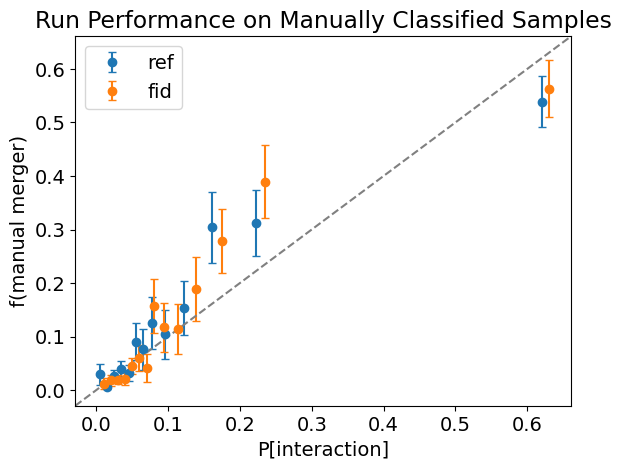

In [11]:
# Plot run performance on manually classified samples
manual_merger = np.in1d(labels, [2,3])
manual_nonmerger = labels==1

for idx, (name, run) in enumerate(runs.items()):
    samp = data[name]['prob_labels_iter']
    assns, bins = sampling.bin_by_count(pmerger(samp), 800, dx_min=0.01)
    
    ftp = sampling.classfraction(
        pmerger(samp)[manual_merger],
        pmerger(samp)[manual_nonmerger],
        add=True,
        alpha=0.16,
        bins=bins,
    )
    
    ek.errorbar(
        sampling.midpts(ftp[0]),
        np.mean(ftp[2], axis=0),
        ylow=ftp[2][0],
        yhigh=ftp[2][1],
        capsize=3,
        label=run['label'],
        color=run['color']
    )
    
ek.oneone()
plt.xlabel("P[interaction]")
plt.ylabel('f(manual merger)')
plt.title('Run Performance on Manually Classified Samples')
plt.legend()
plt.show()

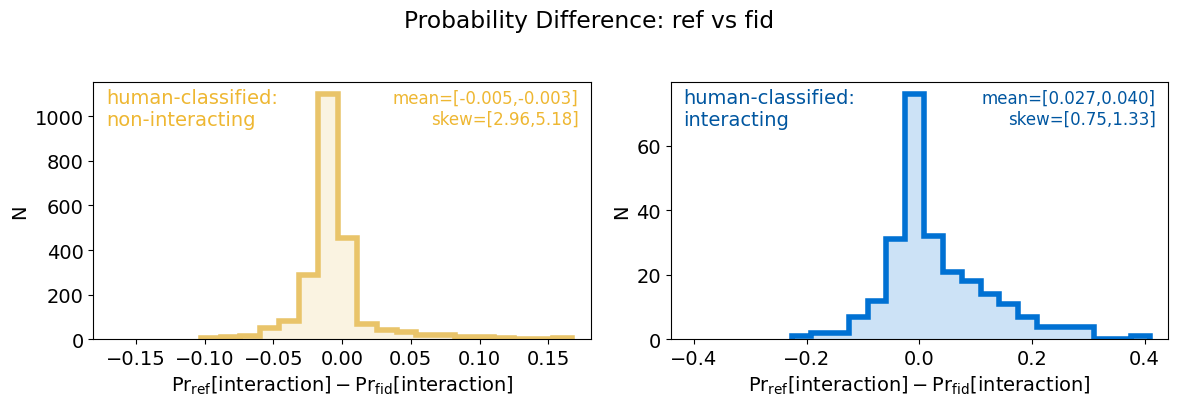

In [12]:
# Plot probability difference distributions for manually classified samples
fig, axarr = plt.subplots(1,2,figsize=(12,4))
hkwargs = {'lw':4,'alpha':0.2, 'bins':20}
ek.hist(dp[np.in1d(labels,[1])], ax=axarr[0], color=colorlists.slides['yellow'], **hkwargs)
ek.hist(dp[np.in1d(labels,[2,3])], ax=axarr[1], color=colorlists.slides['blue'], **hkwargs)

cc = [colorlists.slides['yellow'],colorlists.slides['blue']]
prefixes = ['non-','']  
lgroups = [[1],[2,3]]

for idx,ax in enumerate(axarr):
    ax.set_xlim(np.max(np.abs(ax.get_xlim()))*np.array([-1,1]))
    ax.set_ylabel("N")
    ax.set_xlabel(rf'$\rm Pr_{{{runs[run_names[0]]["label"]}}}[interaction]-Pr_{{{runs[run_names[1]]["label"]}}}[interaction]$')

    mx = sampling.bootstrap_metric( sampling.fmasker(dp[np.in1d(labels,lgroups[idx])]), np.mean )
    sx = sampling.bootstrap_metric( sampling.fmasker(dp[np.in1d(labels,lgroups[idx])]), stats.skew )    
    ek.text(
        0.025, 
        0.975,
        f'''human-classified:
{prefixes[idx]}interacting''',
        ax=ax,
        color=ec.ColorBase(cc[idx]).modulate(-0.1,0.1).base
    )
    ek.text(    
        0.975,
        0.975,
        f'''mean=[{mx[0]:.3f},{mx[1]:.3f}]
skew=[{sx[0]:.2f},{sx[1]:.2f}]''',
        ax=ax,
        color=ec.ColorBase(cc[idx]).modulate(-0.1,0.1).base,
        fontsize=12
    )

plt.suptitle(f'Probability Difference: {runs[run_names[0]]["label"]} vs {runs[run_names[1]]["label"]}', y=1.02)
plt.tight_layout()
plt.show()

## Visual Inspection of Disagreement Cases

In [13]:
# Identify cases where runs disagree
thresh = 0.6
dpthresh = 0.3

pos1 = (pmerger(p1)>thresh)
negpos = (pmerger(p2)>thresh)&(dp<-dpthresh)&(p2[:,4]<frag_threshold)
posneg = (pmerger(p1)>thresh)&(dp>dpthresh)&(p1[:,4]<frag_threshold)
pos2 = (pmerger(p2)>thresh)

groups = [pos1, negpos, posneg, pos2]
run_labels = [ runs[name]['label'] for name in run_names ] 
names = [f'{run_labels[0]}+', f'{run_labels[0]}-/{run_labels[1]}+', f'{run_labels[0]}+/{run_labels[1]}-', f'{run_labels[1]}+']
long_names = [
    f'{runs[run_names[0]]["label"]} Positive',
    rf'$\rm Pr_{{{run_labels[0]}}}[int]<Pr_{{{run_labels[1]}}}[int]$',
    rf'$\rm Pr_{{{run_labels[0]}}}[int]>Pr_{{{run_labels[1]}}}[int]$',
    f'{runs[run_names[1]]["label"]} Positive'
]

for _ in range(len(groups)):
    print(f'{names[_]}: {groups[_].sum()}')

ref+: 238
ref-/fid+: 4
ref+/fid-: 49
fid+: 108


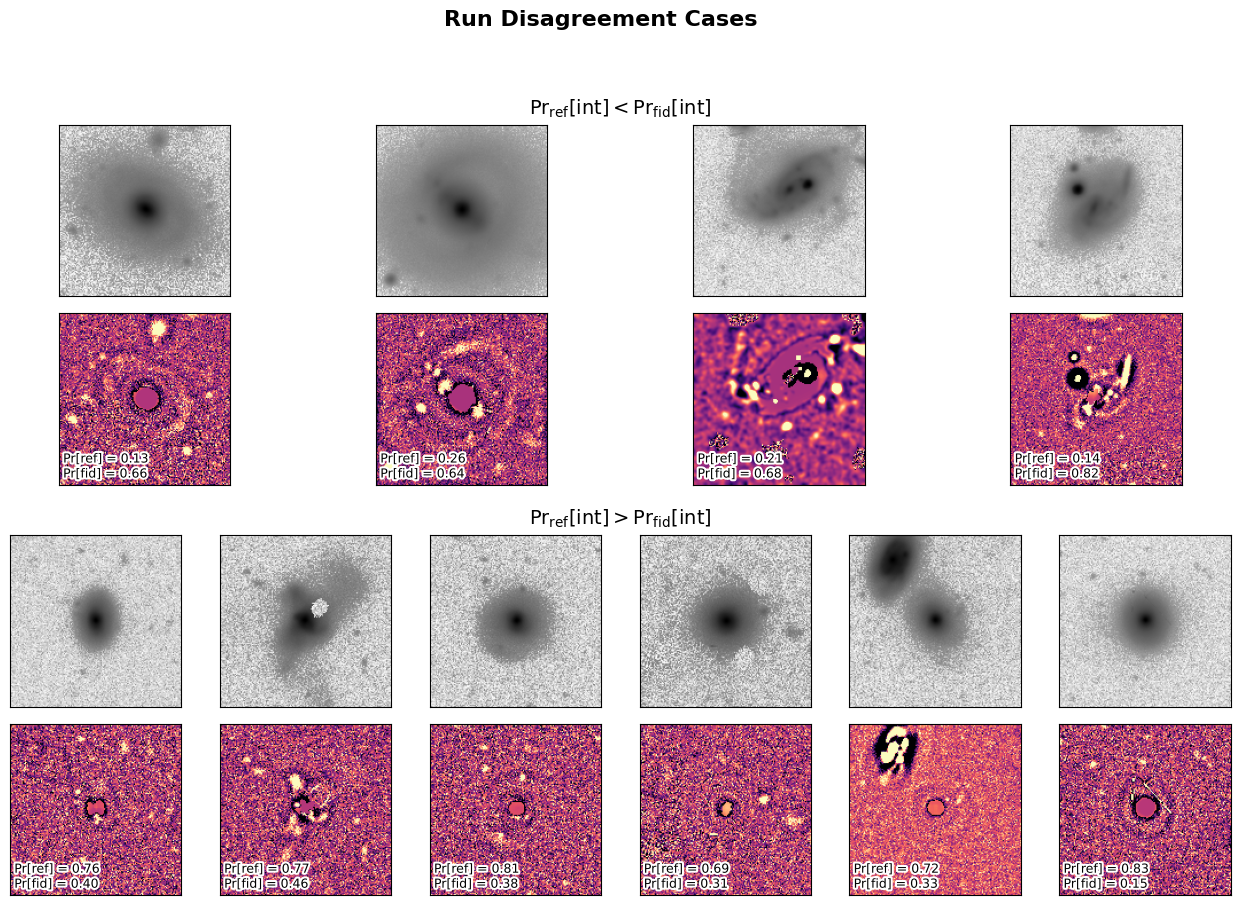

In [14]:
# Create visual comparison of disagreement cases
fig = plt.figure(figsize=(16, 10))

# Create a 2x1 GridSpec for two groups (showing only disagreement groups)
outer_grid = gridspec.GridSpec(2, 1, figure=fig, hspace=0.14)

# Define which groups to display (disagreement cases: groups 1 & 2)
groups_to_display = [1,2]

# Loop through each of the 2 groups
for idx, group_idx in enumerate(groups_to_display):
    # Get the mask for this group and filter image names
    group_mask = groups[group_idx]
    group_images = img_names[group_mask]
    
    if len(group_images) == 0:
        print(f"⚠️  No examples in group {group_idx}: {names[group_idx]}")
        continue
    
    num_examples = min(6, len(group_images))
    inner_grid = gridspec.GridSpecFromSubplotSpec(
        2, num_examples,
        subplot_spec=outer_grid[idx],
        hspace=0.1,
        wspace=0.1
    )
    
    # Randomly select examples from this group
    choices = np.random.choice(group_images, num_examples, replace=False)
    
    # Display each selected example in the grid
    for col in range(num_examples):
        # Load the image data for this example
        img = load_image_by_name(choices[col], data_path)
        
        # Display two versions of the image (grayscale and colored)
        for row in range(2):
            ax = fig.add_subplot(inner_grid[row, col])
            
            if row == 0:
                # Top row: Display grayscale image
                ax.imshow(
                    img[row + 1],
                    origin='lower',
                    cmap='Greys',
                    norm=colors.SymLogNorm(linthresh=0.1)
                )
            else:
                # Bottom row: Display HF image
                ek.imshow(img[row + 1], ax=ax, cmap='magma')
                
                # Add probability text overlay
                img_index = np.where(img_names == choices[col])[0][0]
                ek.text(
                    0.025,
                    0.025,
                    rf'''Pr[{run_labels[0]}] = {pmerger(p1)[img_index]:.2f}
Pr[{run_labels[1]}] = {pmerger(p2)[img_index]:.2f}''',
                    ax=ax,
                    fontsize=9,
                    bordercolor='w',
                    color='k',
                    borderwidth=3
                )
            
            # Remove axis ticks
            ax.set_xticks([])
            ax.set_yticks([])
    
    # Add title above this group's panel
    bbox = outer_grid[idx].get_position(fig)
    fig.text(
        bbox.x0 + bbox.width / 2,
        bbox.y1 + 0.005,
        f'{long_names[group_idx]}',
        ha='center',
        va='bottom',
        fontsize=14,
        fontweight='bold'
    )

plt.suptitle('Run Disagreement Cases', y=0.995, fontsize=16, fontweight='bold')
plt.show()

## Detailed Inspection: Cases Where Runs Disagree Strongly

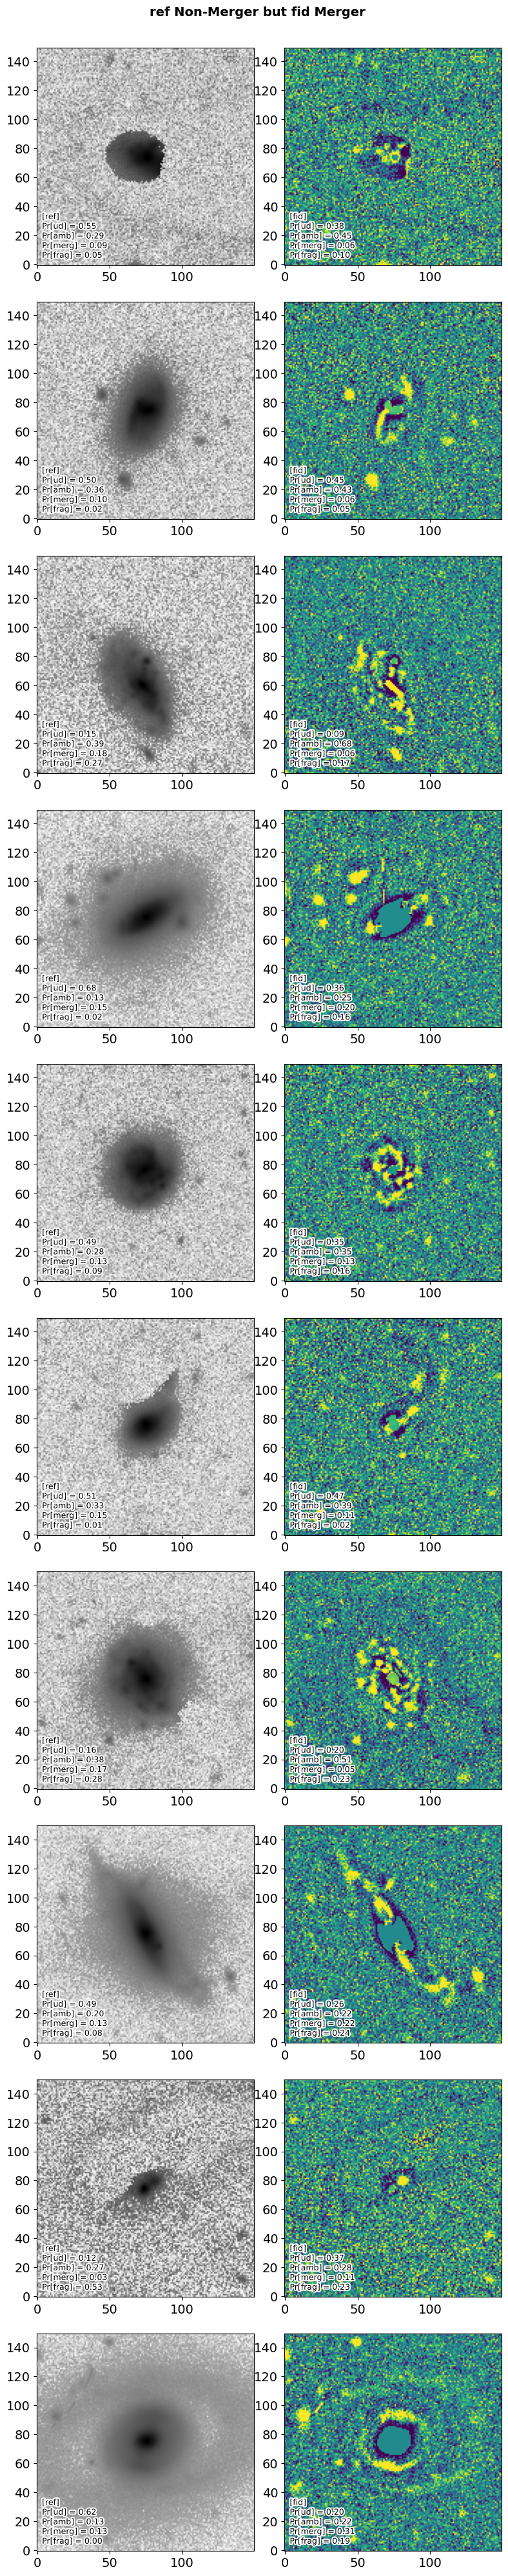

In [15]:
# Find cases where first run says non-merger but second run says merger
candidates = ~data[run_names[0]]['is_possible_merger'] & data[run_names[1]]['is_possible_merger']
n_candidates = min(10, candidates.sum())

if n_candidates == 0:
    print(f"✅ No strong disagreements found between {runs[run_names[0]]['label']} and {runs[run_names[1]]['label']}")
else:
    fig, axarr = plt.subplots(n_candidates, 2, figsize=(8, 4*n_candidates))
    if n_candidates == 1:
        axarr = axarr.reshape(1, -1)

    for adx, idx in enumerate(np.random.choice(np.arange(len(img_names))[candidates], replace=False, size=n_candidates)):
        img = load_image_by_name(img_names[idx], data_path)
        
        axarr[adx, 0].imshow(
            img[1],
            origin='lower',
            cmap='Greys',
            norm=colors.SymLogNorm(linthresh=0.1)
        )
        ek.imshow(img[2], ax=axarr[adx,1])

        # Add statistics for first run
        ek.text(
            0.025, 0.025,
            f"""[{runs[run_names[0]]['label']}]
Pr[ud] = {p1[idx, 1]:.2f}
Pr[amb] = {p1[idx, 2]:.2f}
Pr[merg] = {p1[idx, 3]:.2f}
Pr[frag] = {p1[idx, 4]:.2f}""",
            ax=axarr[adx,0],
            fontsize=9,
            bordercolor='w',
            color='k',
            borderwidth=3
        )
        
        # Add statistics for second run
        ek.text(
            0.025, 0.025,
            f"""[{runs[run_names[1]]['label']}]
Pr[ud] = {p2[idx, 1]:.2f}
Pr[amb] = {p2[idx, 2]:.2f}
Pr[merg] = {p2[idx, 3]:.2f}
Pr[frag] = {p2[idx, 4]:.2f}""",
            ax=axarr[adx,1],
            fontsize=9,
            bordercolor='w',
            color='k',
            borderwidth=3
        )

    plt.suptitle(f'{runs[run_names[0]]["label"]} Non-Merger but {runs[run_names[1]]["label"]} Merger', 
                 y=1.00, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

## Probability Distribution Comparison

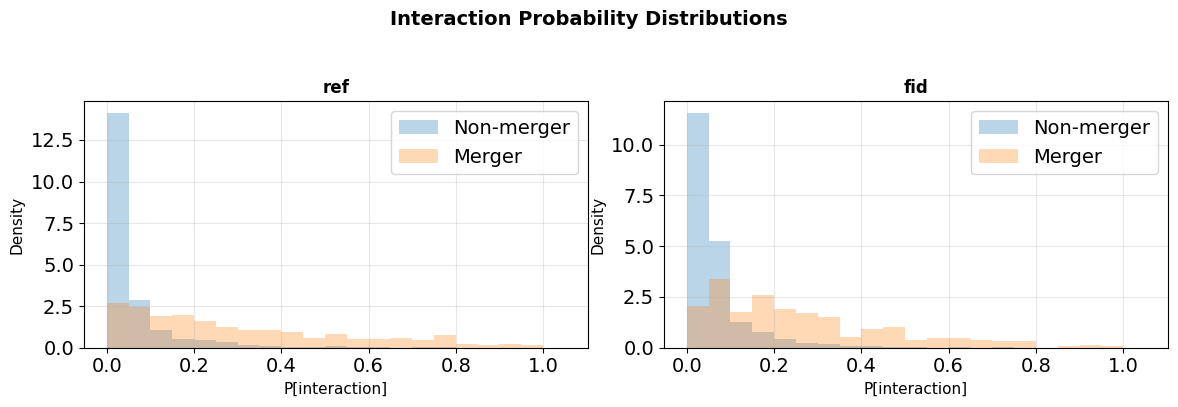

In [16]:
# Plot probability distributions for manually classified samples
manual_merger = (labels==2)|(labels==3)
manual_nonmerger = (labels==1)

hkwargs = {'alpha': 0.3, 'lw': 3, 'bins': np.arange(0., 1.1, 0.05), 'density': True}

fig, axarr = plt.subplots(1, 2, figsize=(12, 4))

for idx, (name, run) in enumerate(runs.items()):
    prob_labels = data[name]['prob_labels_iter']
    
    # Plot distributions
    axarr[idx].hist(pmerger(prob_labels)[manual_nonmerger], label='Non-merger', **hkwargs)
    axarr[idx].hist(pmerger(prob_labels)[manual_merger], label='Merger', **hkwargs)
    axarr[idx].set_xlabel('P[interaction]', fontsize=11)
    axarr[idx].set_ylabel('Density', fontsize=11)
    axarr[idx].set_title(run['label'], fontsize=12, fontweight='bold')
    axarr[idx].legend()
    axarr[idx].grid(alpha=0.3)

plt.suptitle('Interaction Probability Distributions', y=1.02, fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Summary Statistics

In [17]:
# Print summary statistics
print("\n" + "="*80)
print("RUN COMPARISON SUMMARY")
print("="*80)

for name in data.keys():
    print(f"\n{runs[name]['label']} ({name}):")
    print(f"   Path: {runs[name]['path']}")
    print(f"   Classifier: {classifier_used[name]}")
    print(f"   Total galaxies: {len(data[name]['img_names'])}")
    print(f"   Merger candidates: {data[name]['is_possible_merger'].sum()}")
    print(f"   Mean interaction probability: {np.nanmean(pmerger(data[name]['prob_labels_iter'])):.4f}")

# Agreement statistics
print("\n" + "-"*80)
print("Agreement Statistics:")
print("-"*80)

# Both agree on merger
both_merger = data[run_names[0]]['is_possible_merger'] & data[run_names[1]]['is_possible_merger']
print(f"Both identify as merger: {both_merger.sum()} ({100*both_merger.sum()/len(img_names):.2f}%)")

# Both agree on non-merger
both_non_merger = ~data[run_names[0]]['is_possible_merger'] & ~data[run_names[1]]['is_possible_merger']
print(f"Both identify as non-merger: {both_non_merger.sum()} ({100*both_non_merger.sum()/len(img_names):.2f}%)")

# Disagreement
disagree = data[run_names[0]]['is_possible_merger'] != data[run_names[1]]['is_possible_merger']
print(f"Disagree: {disagree.sum()} ({100*disagree.sum()/len(img_names):.2f}%)")

# Specific disagreement patterns
only_run1 = data[run_names[0]]['is_possible_merger'] & ~data[run_names[1]]['is_possible_merger']
only_run2 = ~data[run_names[0]]['is_possible_merger'] & data[run_names[1]]['is_possible_merger']
print(f"   Only {runs[run_names[0]]['label']}: {only_run1.sum()}")
print(f"   Only {runs[run_names[1]]['label']}: {only_run2.sum()}")

print("\n" + "="*80)
print(f"Configuration: {config_path}")
print(f"Fragmentation threshold: {frag_threshold}")
print("="*80)


RUN COMPARISON SUMMARY

ref (run1):
   Path: ../output/reference
   Classifier: Neural Network
   Total galaxies: 22913
   Merger candidates: 518
   Mean interaction probability: 0.0774

fid (run2):
   Path: ../output/fiducial
   Classifier: Neural Network
   Total galaxies: 22913
   Merger candidates: 325
   Mean interaction probability: 0.0794

--------------------------------------------------------------------------------
Agreement Statistics:
--------------------------------------------------------------------------------
Both identify as merger: 226 (0.99%)
Both identify as non-merger: 22296 (97.31%)
Disagree: 391 (1.71%)
   Only ref: 292
   Only fid: 99

Configuration: ../config.yaml
Fragmentation threshold: 0.25
